In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
from PIL import Image
import itertools

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [ ]:
# Assuming the dataset was downloaded using kagglehub
# and the path is stored in paultimothymooney_chest_xray_pneumonia_path

# Update the train_data_path with the correct path
train_data_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train')

filepaths = []
labels = []

folds = os.listdir(train_data_path)
for file in folds:
    foldpath = os.path.join(train_data_path, file)
    filelist = os.listdir(foldpath)

    for f in filelist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(file)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
df

filepaths      label
0     /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
1     /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
2     /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
3     /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
4     /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
...                                                 ...        ...
5211  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
5212  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
5213  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
5214  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
5215  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA

[5216 rows x 2 columns]

In [ ]:
df['label'].value_counts()

label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64

In [ ]:
# Update the train_data_path with the correct path
valid_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'val')
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
valid['label'].value_counts()

label
NORMAL       8
PNEUMONIA    8
Name: count, dtype: int64

In [ ]:
test_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'test')
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for f in folds:
    foldpath = os.path.join(test_data_dir,f)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(f)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
test

filepaths      label
0    /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
1    /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
2    /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
3    /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
4    /root/.cache/kagglehub/datasets/paultimothymoo...     NORMAL
..                                                 ...        ...
619  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
620  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
621  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
622  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA
623  /root/.cache/kagglehub/datasets/paultimothymoo...  PNEUMONIA

[624 rows x 2 columns]

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


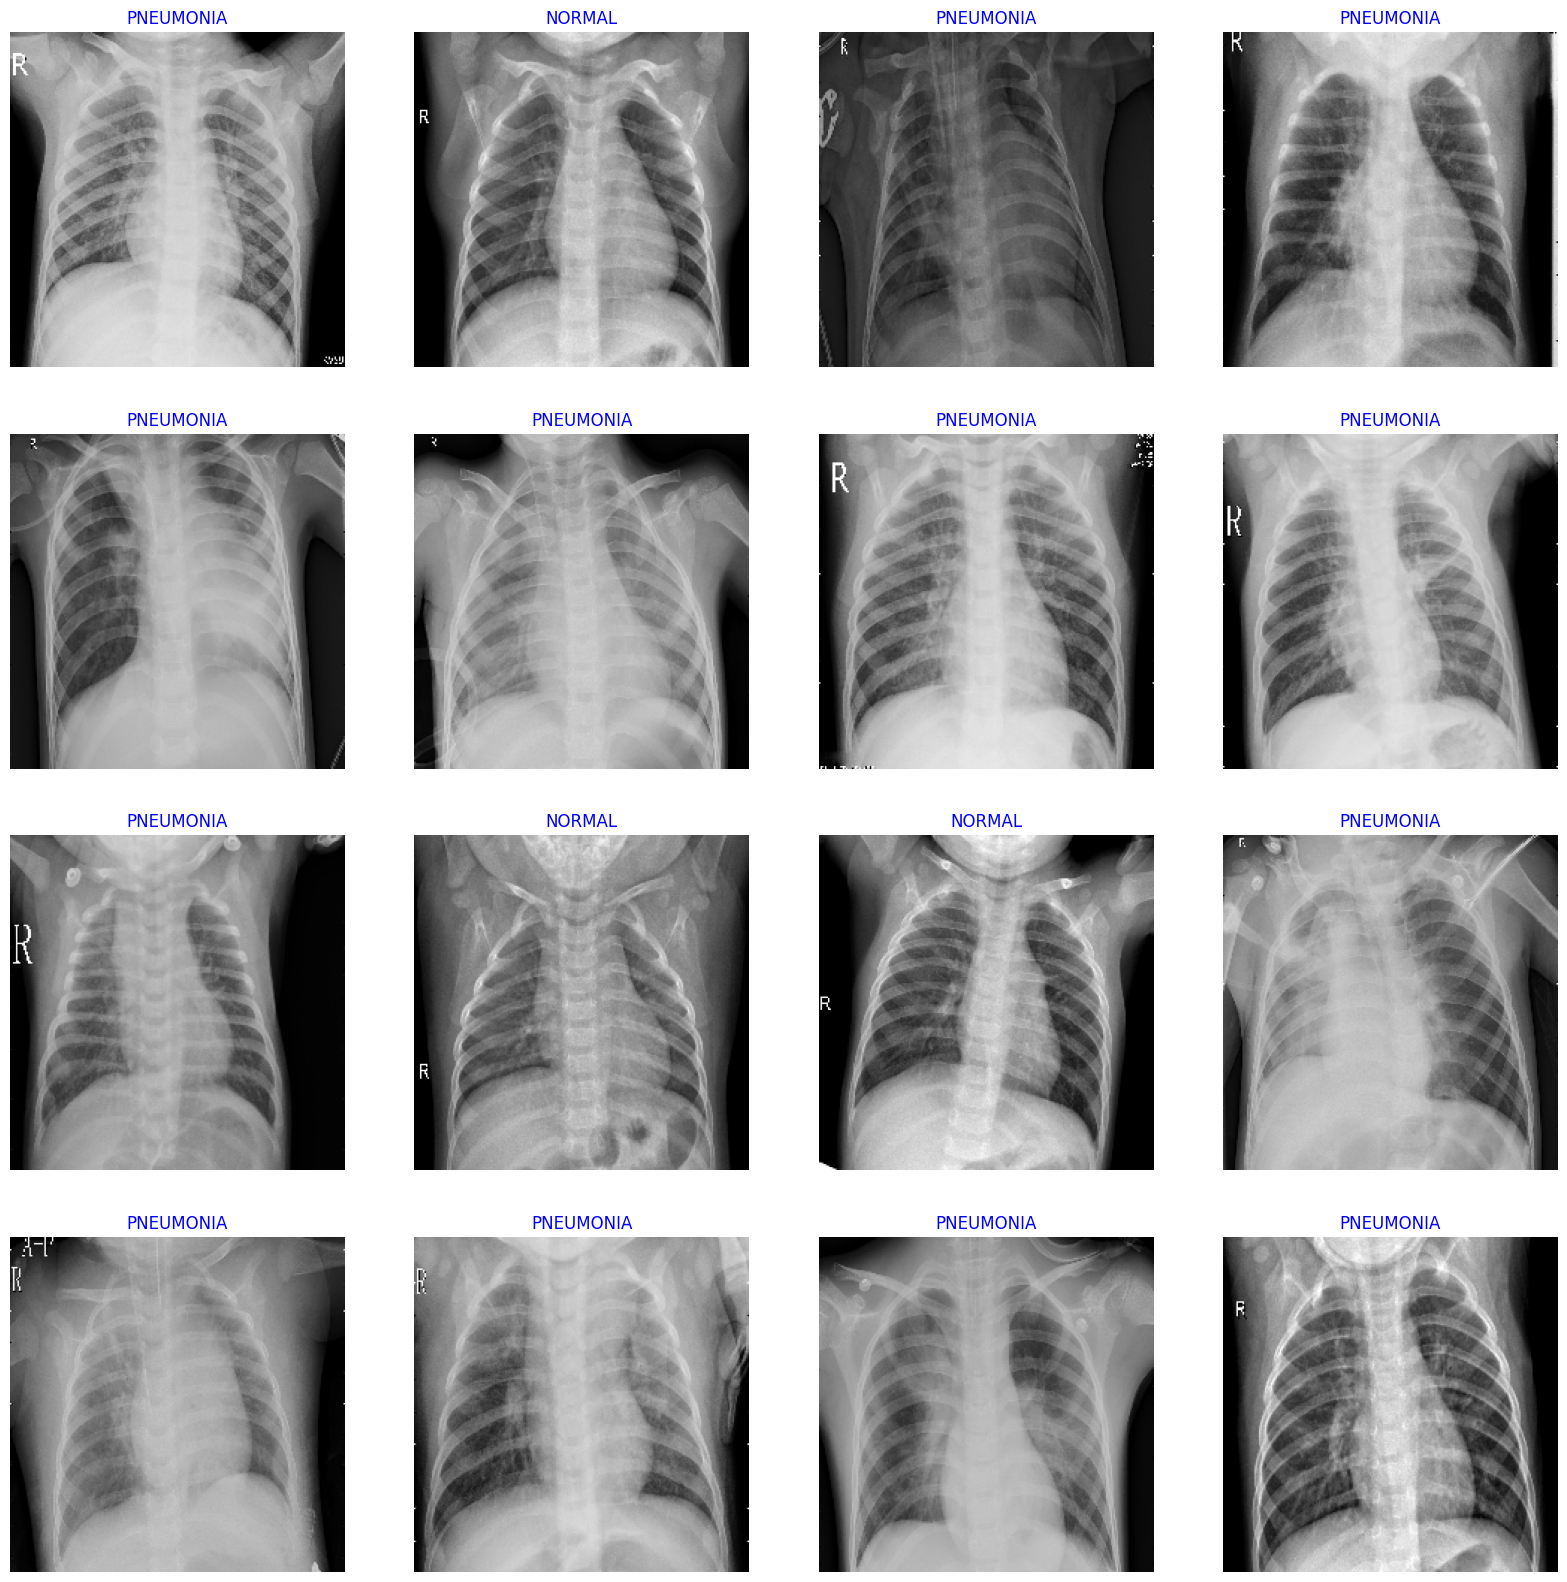

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model

model = create_cnn_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,262,434 (8.63 MB)

 Trainable params: 2,262,434 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
epochs = 50

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 228ms/step - accuracy: 0.6814 - loss: 3.0612 - val_accuracy: 0.7050 - val_loss: 0.6238
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.7678 - loss: 0.4882 - val_accuracy: 0.8065 - val_loss: 0.3554
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.8486 - loss: 0.3358 - val_accuracy: 0.8966 - val_loss: 0.2399
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.8843 - loss: 0.2668 - val_accuracy: 0.9368 - val_loss: 0.1834
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.9267 - loss: 0.1958 - val_accuracy: 0.9579 - val_loss: 0.1225
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.9344 - loss: 0.1695 - val_accuracy: 0.9674 - val_loss: 0.1001
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.9467 - loss: 0.1467 - val_accuracy: 0.9770 - val_loss: 0.0862
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - accuracy: 0.9522 - loss: 0

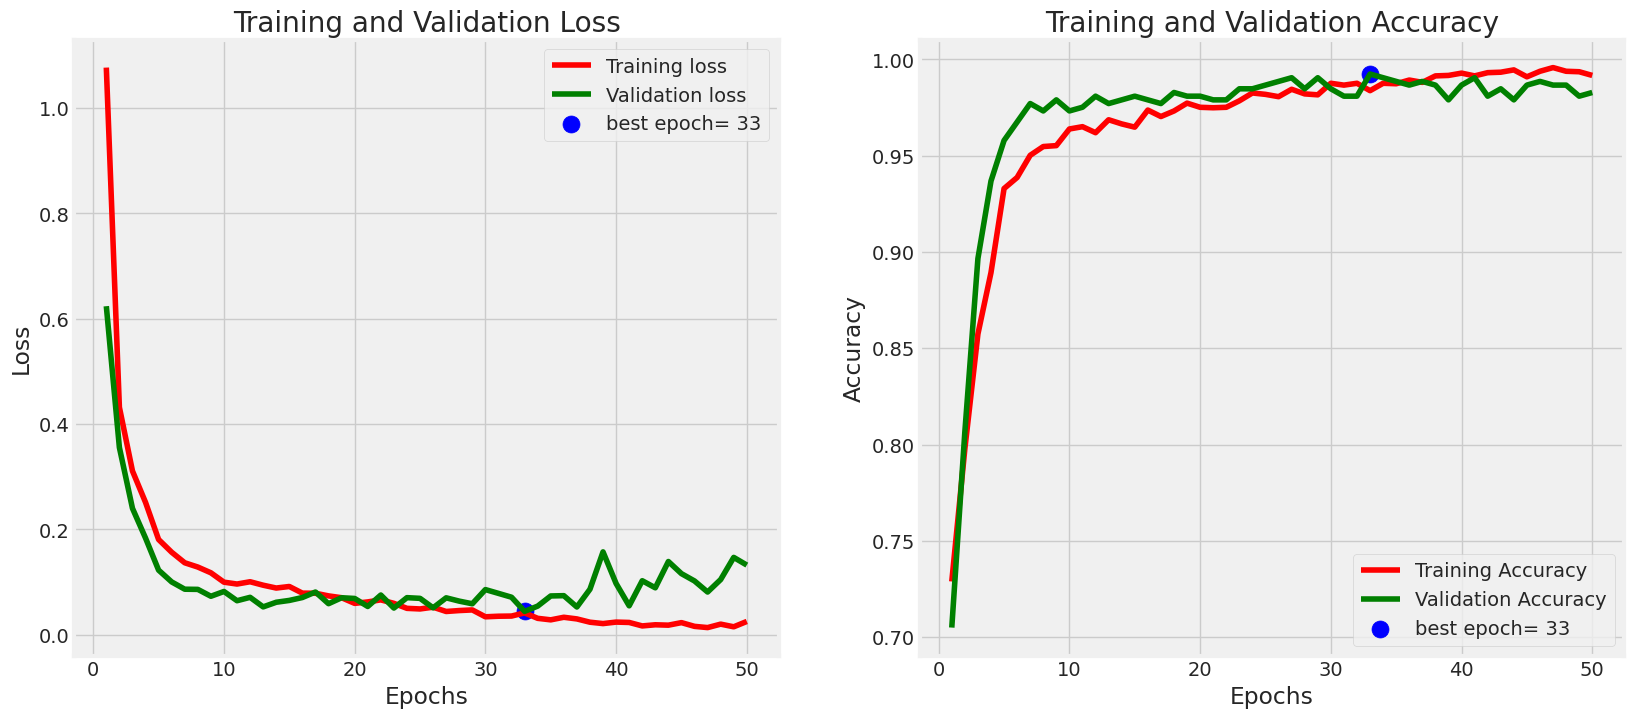

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 147ms/step - accuracy: 0.9983 - loss: 0.0133
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.9869 - loss: 0.0764
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9782 - loss: 0.0951
Train Loss:  0.006288826931267977
Train Accuracy:  0.9992809295654297
--------------------
Validation Loss:  0.1320774257183075
Validation Accuracy:  0.982758641242981
--------------------
Test Loss:  0.09337026625871658
Test Accuracy:  0.9712643623352051


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step


array([[120,  13],
       [  2, 387]])

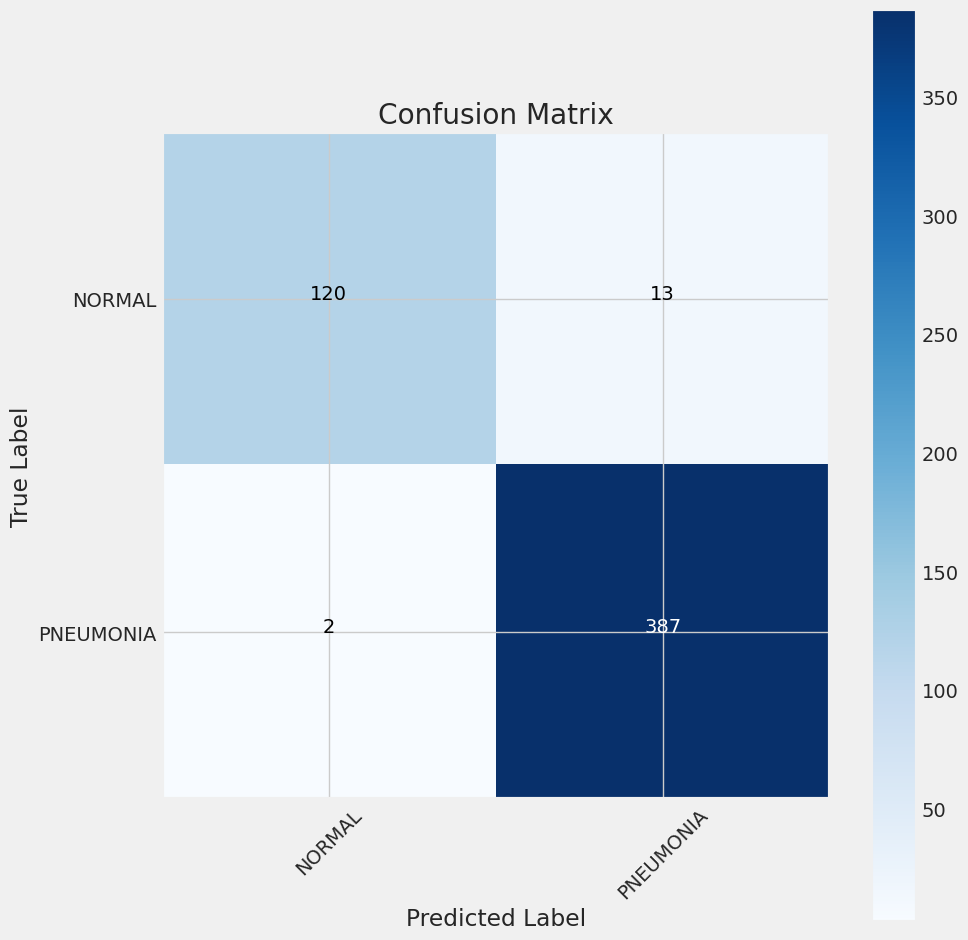

In [ ]:

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(test_gen.classes,y_pred,target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.90      0.94       133
   PNEUMONIA       0.97      0.99      0.98       389

    accuracy                           0.97       522
   macro avg       0.98      0.95      0.96       522
weighted avg       0.97      0.97      0.97       522



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


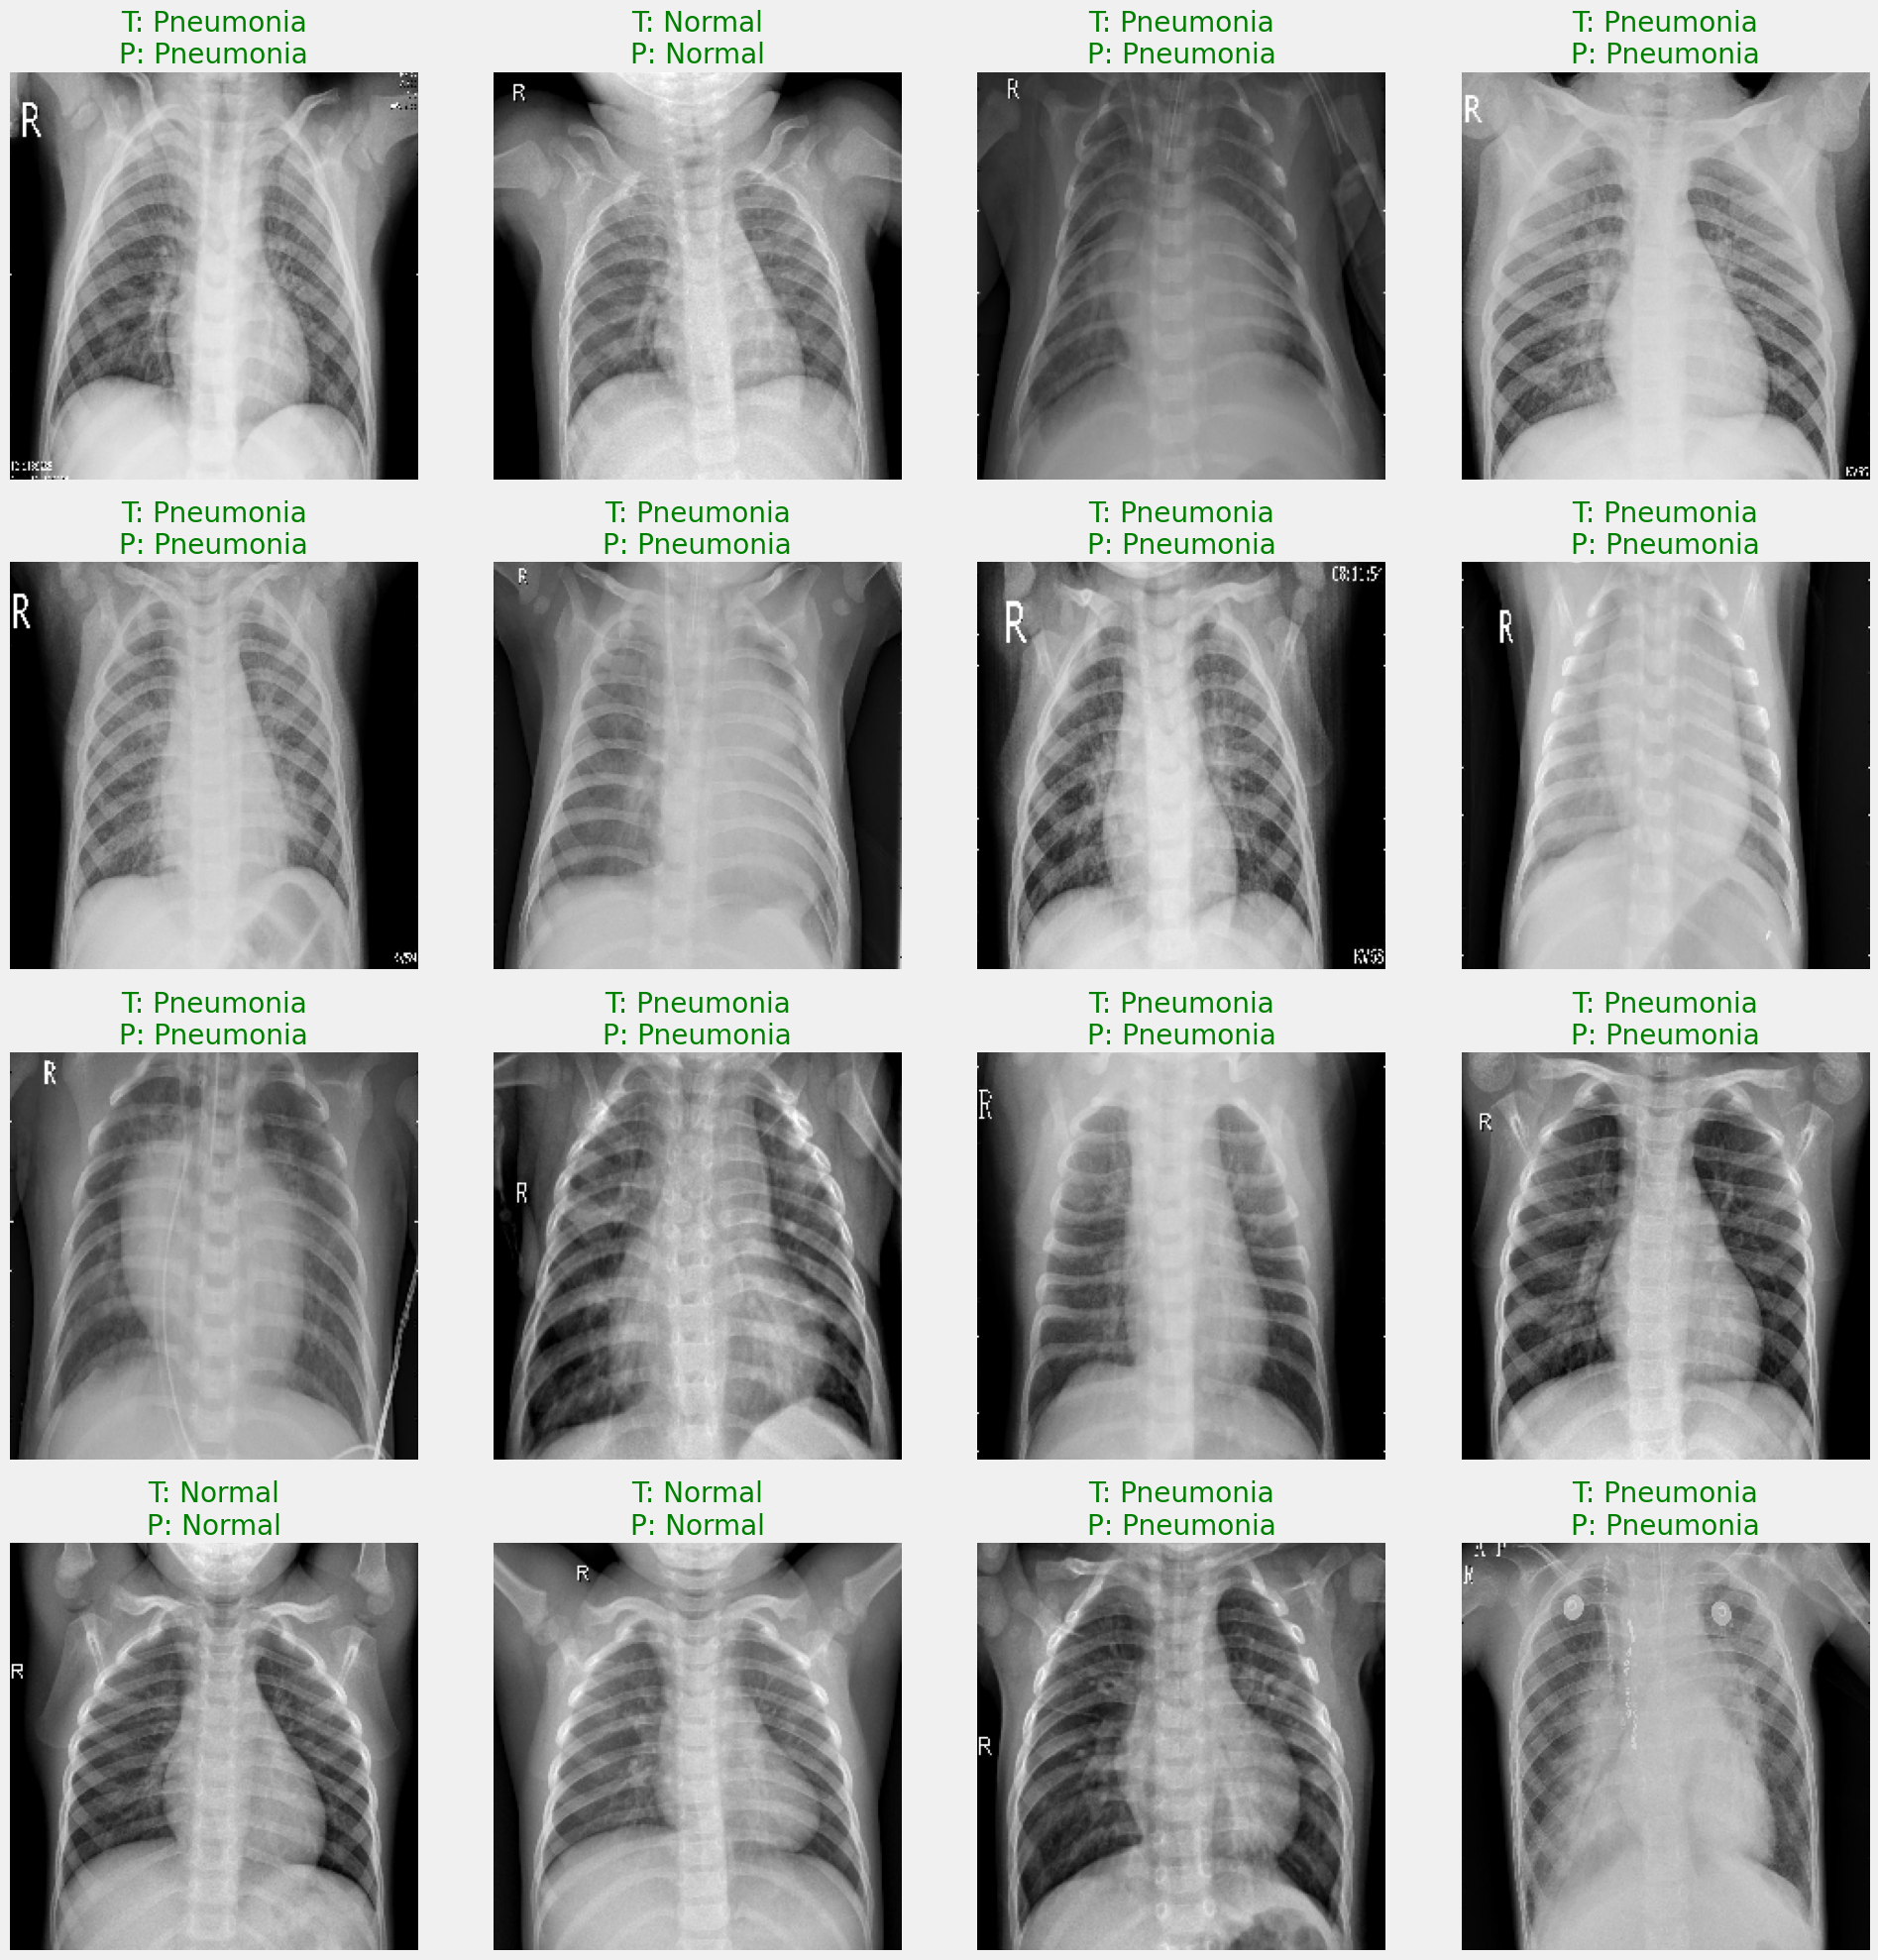

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

x_test, y_true = next(test_gen)
batch_size = x_test.shape[0]
n_images = min(16, batch_size)

x_test = x_test[:n_images]
y_true = y_true[:n_images]

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

plt.figure(figsize=(20, 20))
for i in range(n_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis("off")
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()


In [ ]:
#save to h5 file

from tensorflow.keras.models import load_model

model.save('Custom_CNN_1.h5')